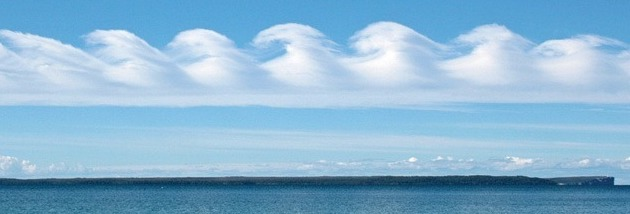

# Lab 4: Shear instability

In this lab, we will simulate instability of parallel shear flow and discuss: 

- using a passive tracer to visualize the flow
- unstable growth of small perturbations
- dissipation and energy 

To use this notebook, you will need Python 3 and the latest version of [Dedalus](http://dedalus-project.org/) installed on your local machine. 

# Background

## Parallel shear flow

In this lab we will examine the evolution of simple shear flows. These are flows that satisfy the equations of motion for a single shallow water layer that we have previously seen. The only difference is that we will impose an initial velocity in the $x$-direction, and allow it to vary in the $y$-direction:

$$
\boldsymbol{u} = \left( U(y), 0 \right).
$$

This type of flow is called a *parallel shear flow* because the flow is parallel at every point --- there is no curvature in the flow --- but it has some variation in the perpendicular direction. Notice that this flow automatically (and trivially) satisfies the incompressibility condition, $u_x + v_y = 0$. 

In this lab we will ignore the effect of rotation, that is, we will look at the case of $f_0 = \beta = 0$. 

## The Kelvin-Helmholtz Problem

The simplest type of parallel shear flow is the *Kelvin-Helmholtz problem*. In this problem, we consider a flow initially moving with constant velocity $U$ in the lower half of the domain and with velocity $-U$ in the upper half of the domain,

$$
\boldsymbol{u}(x,y,0) = \left\{ \begin{array}{ccc} - U & \mbox{for} & y \ge 0, \\ U & \mbox{for} & y < 0. \end{array} \right. 
$$



These kinds of flows frequently occur in nature, for example when two air masses of similar density flow over each other in opposite directions. In our application, we imagine that this flow has been set up by moving plates at the upper and lower boundaries of the domain in opposite directions. 

The equations of motion for this flow (taking $\rho = 1$) are

$$ 
\partial_t u + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} u + \partial_x p = A \nabla^2 u, \qquad x-\mbox{momentum equation}
$$

$$ 
\partial_t v + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} v + \partial_y p = A \nabla^2 v, \qquad y-\mbox{momentum equation} 
$$

$$ 
\boldsymbol{\nabla}\boldsymbol{\cdot}\boldsymbol{u} = 0. \qquad \mbox{incompressibility}
$$

Since the flow is unstable, we expect the initial flow profile to break up and eventually dissipate. The dissipation is achieved by diffusion, which appears as the terms $A \nabla^2 u$ and $A \nabla^2 v$ on the right-hand sides of the $x$ and $y$ momentum equations. Here, the parameter $A$ represents the *diffusivity*. 

We will evolve the equations in a rectangular box with $L_x = 2$ and $L_y = 1$. For boundary conditions, we will assume that the box is periodic in $x$ direction, and use a *no-slip boundary condition* in the $y$ direction. This means that the velocity at top and bottom matches the velocity of the boundary itself: 

$$
u = -U, \; v = 0 \qquad \mbox{at} \qquad y = Ly/2,
$$

$$
u = U, \; v = 0 \qquad \mbox{at} \qquad y = -Ly/2,
$$

## Passive tracer

In a real laboratory experiment, we often use colored dye to help visualize flows. By adding a few drops of dye, we can see the complicated flow patterns and structures that form. In nature, the same thing happens with water vapour (in the atmosphere) or phytoplankton (in the ocean). 

We will use a similar technique in our simulation using a kind of numerical dye called a *passive tracer*. Specifically, we add another equation to solve

$$ \partial_t C + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} C = A \nabla^2 C $$

Here, $C(x,y,t)$ is the concentration of a dye that is moved around by the flow: it is *tracer* because it allows us to trace the evolution of parcels of fluid, and it is *passive* because it does not affect the evolution of the flow in any way. 

We will start our experiment with the tracer in the lower half the domain. Specifically, we will set the initial value of $C$ to be $1$ in the lower half of the domain, and $0$ in the upper half

$$
C(x,y,0) = \left\{ \begin{array}{ccc} 0 & \mbox{for} & y \ge 0, \\ 1 & \mbox{for} & y < 0. \end{array} \right. 
$$

Just as with the momentum equations, the initial tracer distribution will be deformed by the unstable flow and will be ultimately dissipated. This is achieved by a diffusion term $A \nabla^2 C$ on the right-hand side of the passive tracer evolution equation. We don't have to use the same value $A$ for the diffusivity in the momentum equations and the passive tracer equation: it is just a convenience. 

# Setting up the experiment

## Libraries

First we import the libraries we will use, including `numpy`, `matplotlib` and `dedalus`. 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from dedalus import public as de
from dedalus.extras import flow_tools
from IPython import display

ImportError: Make sure to build using `python3 setup.py build_ext --inplace`

## Output and logging

Now we add some commands to plot figures and show log messages in the `jupyter` window.

In [ ]:
%matplotlib inline

import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

## Parameters

The parameters in our problem are the size and resolution of the domain, the integration time, and the diffusivity. 

In [ ]:
# Domain size and resolution 
Lx, Ly = (2., 1.)
nx, ny = (96, 48)

# Integration time
T = 10.01 

# Diffusivity
A = 1e-4

## Problem Domain

Now specify the domain. Here the domain is a 2D channel that is periodic in the $x$ direction, but has non-trivial boundary conditions in the $y$ direction. So the natural basis functions are Fourier (sines and cosines) in $x$ and Chebyshev (polynomial) in $y$. 

In [ ]:
# Create bases and domain
x_basis = de.Fourier('x', nx, interval=(0, Lx), dealias=3/2)
y_basis = de.Chebyshev('y',ny, interval=(-Ly/2, Ly/2), dealias=3/2)
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

## Initial value problem

Now let's define our initial value problem and add the problem parameters and equations. We need to think a little bit about how to enter the equations so they are appropriate for Dedalus. Specifically, the LHS of the equations needs to be linear and first order in $y$. To do this, we introduce some new variables to deal with the $y$- derivatives of `u`, `v`, and `C`, namely, `uy`, `vy`, `Cy`.

For example, the $x$-momentum equation is 

$$
\partial_t u + u \, \partial_x u + v \, \partial_y u + \partial_x p = A \, \partial_x^2 u + A \, \partial_y^2 u. 
$$

Because the domain is periodic in the $x$-direction, the $x$-basis functions are also periodic, for example $\sin k_x x$ or $\cos k_x x$.  Then, differentiation with respect to $x$ is very simple: it just gives a multiple of $k_x$. 

However, the domain is not periodic in the $y$-direction, so we need to make sure that the $x$-momentum equation involves at most first-order derivatives with respect to $y$. To do this, we introduce a new variable, $u_y$. This variable and $u$ are simply related

$$
u_y = \partial_y \, u. 
$$

We can now write the $x$-momentum equation so that it only has first-order $y$-derivatives: 

$$
\partial_t u + u \, \partial_x u + v \, u_y + \partial_x p = A \, \partial_x^2 u + A \, \partial_y u_y. 
$$

Finally, we need to rewrite the equation so that the linear terms are on the left-hand side and nonlinear terms are on the right-hand side: 

$$
\partial_t u + \partial_x p - A \, \partial_x^2 u - A \, \partial_y u_y  =  - u \, \partial_x u - v \, u_y.
$$

We also have the auxiliary equation, which is already linear and first order: 
$$
u_y - \partial_y \, u = 0. 
$$

In Dedalus, these is entered as 

```
problem.add_equation("dt(u) + dx(p) - A*(dx(dx(u)) + dy(uy)) = - u*dx(u) - v*uy")
problem.add_equation("uy - dy(u) = 0")
```

***Rewrite the $y$-momentum equation, incompressibility condition, and passive tracer equation in a form suitable for Dedalus, then enter them below. The equations for `u` and `uy` have already been entered for you.***

In [ ]:
problem = de.IVP(domain, variables=['p','u','v','uy','vy','C','Cy'])

problem.parameters['A'] = A

problem.add_equation("dt(u) + dx(p) - A*(dx(dx(u)) + dy(uy)) = - u*dx(u) - v*uy")
problem.add_equation("uy - dy(u) = 0")
#problem.add_equation("...")

## Boundary conditions. 

Next, we set our boundary conditions.  "Left" boundary conditions are applied at $y=-Ly/2$ and "right" boundary conditions are applied at $y=+Ly/2$.

In [ ]:
problem.add_bc("left(u) = 0.5")
problem.add_bc("right(u) = -0.5")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("integ(p,'y') = 0", condition="(nx == 0)")
problem.add_bc("left(Cy) = 0")
problem.add_bc("right(Cy) = 0")

We impose a *no-slip boundary condition* for the velocity, so $u$ and $v$ at the boundaries must match the velocity of the boundary itself. In our problem, the upper boundary is moving at speed $-0.5$ in the $x$-direction and the lower boundary is moving at speed $0.5$ in the $x$-direction, so the boundary conditions for $u$ and $v$ are

$$
\left( u, v \right) = \left\{ \begin{array}{ccc} \left( -0.5, 0 \right) & \mbox{at} & y = Ly/2 \\ \left( 0.5, 0 \right) & \mbox{at} & y = -Lx/2 \end {array} \right.
$$

Note that we have a special boundary condition for the $k_x=0$ mode (singled out by `condition="(nx==0)"`).  This is because the continuity equation implies $\partial_y v=0$ if $k_x=0$; thus, $v=0$ on the top and bottom are redundant boundary conditions.  We replace one of these with a choice for the integral of the pressure.

The boundary conditions for the passive tracer concentration are *no-flux* at the top or bottom: 

$$
\frac{\partial C}{\partial y} = \left\{ \begin{array}{ccc} 0  & \mbox{at} & y = Ly/2 \\ 0 & \mbox{at} & y = -Lx/2 \end {array} \right.
$$

This ensures that none of the passive tracer escapes the domain. 

## Solver

Now we create the solver, specifying the timestepper that you want to use. We'll also specify how long to run the simulation. 

In this experiment we will not set the timestep in advance. Rather, we will let it *adapt* to flow so that the simulation needs a smaller timestep if the flow is evolving rapidly. This is achieved by using an option called `CFL`, which stands for the Courant-Friedrcihs-Lewy condition, which tells us how small we need to make the timestep in order for the simulation to converge. 

In [3]:
solver =  problem.build_solver(de.timesteppers.RK443)

solver.stop_sim_time = T
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

initial_dt = 0.2*Lx/nx
cfl = flow_tools.CFL(solver,initial_dt,safety=0.8)
cfl.add_velocities(('u','v'))

NameError: name 'problem' is not defined

## Initial conditions

Now we set our initial conditions, which we describe in more detail below. If you'd like to change the initial conditions, make sure that they match the boundary conditions that you imposed above --- or just modify the boundary conditions to match your new initial condition. Remember to rerun the entire notebook when you change the initial conditions. 

In [4]:
# Domain and variables
x = domain.grid(0)
y = domain.grid(1)

u  = solver.state['u']
uy = solver.state['uy']
v  = solver.state['v']
vy = solver.state['vy']
C  = solver.state['C']
Cy = solver.state['Cy']

# Initial condition: base state flow in x-direction 
a = 0.05
flow = -0.5
u['g'] = flow*np.tanh(y/a)

# Initial condition: perturbation in y-direction
sigma = 0.2
amp = -0.2
v['g'] = amp*np.sin(2.0*np.pi*x/Lx)*np.exp(-(y*y)/(sigma*sigma))

# Initial condition: tracer field concentration used for visualization
C['g'] = 0.5*(1-np.tanh(y/a))

# Also calculate the initial value of uy, vy, Cy
u.differentiate('y',out=uy)
v.differentiate('y',out=vy)
C.differentiate('y',out=Cy)

NameError: name 'domain' is not defined

For the velocity in the $x$-direction, we approximate the discontinuous step function $U(y)$ with a tanh function with narrow width,

$$
u = U_0 \, \tanh \frac{y}{a}, \qquad \mbox{at} \qquad t = 0,
$$

where $U_0 = -0.5$ is the initial flow speed and $a = 0.05$ is the width of the tanh function. To illustrate, we plot the profile of $u$ as a function of $y$ below. 

In [5]:
# Plot the initial u-velocity
X = domain.grid(0,scales=domain.dealias)
Y = domain.grid(1,scales=domain.dealias)

fig, ax = plt.subplots(figsize=(10,5))
p = ax.scatter(Y,u['g'][0,:])
ax.set_xlim([-Ly/2,Ly/2])
ax.set(title='u-velocity (t = 0)')
ax.set(xlabel='y')

NameError: name 'domain' is not defined

For the initial velocity in the $y$-direction, we will use a very small initial sinusoidal perturbation centred at $y = 0$, 

$$
v = V_0 \, \sin \left( \frac{2 \pi x}{L_x} \right) \, \mbox{e}^{-y^2/\sigma^2} \qquad \mbox{at} \qquad t = 0,
$$

where $V_0 = -0.2$ is the amplitude of the velocity perturbation and $\sigma = 0.2$ is the width of the perturbation centred at $y = 0$. 

Below we plot the profile of $v$ as a function of $x$. Note that $v$ also depends upon $y$ (unlike the initial values for both $u$ and $C$). This is illustrated by plotting several cross-sections of $v$. 

NameError: name 'X' is not defined

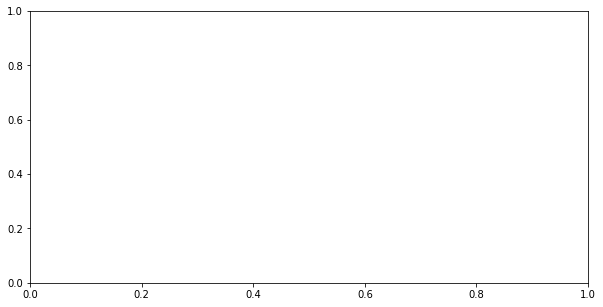

In [6]:
# Plot the initial v-velocity
fig, ax = plt.subplots(figsize=(10,5))
p = ax.scatter(X,v['g'][:,0],label='y=%4.2f' %Y[0,0])
p = ax.scatter(X,v['g'][:,24],label='y=%4.2f' %Y[0,24])
p = ax.scatter(X,v['g'][:,36],label='y=%4.2f' %Y[0,36])
ax.set_xlim([0,Lx])
ax.set(title='v-velocity (t = 0)')
ax.set(xlabel='x')
plt.legend(loc='lower left')

For the initial passive tracer concentration, we again approximate the discontinuous step function with a tanh function with narrow width,

$$
C = 0.5 \left( 1 - \tanh \frac{y}{a} \right), \qquad \mbox{at} \qquad t = 0.
$$

This function is $1$ in the lower half of the domain, $0$ in the upper half, and smoothly transitions between the two values over a width $a = 0.05$. 

In [ ]:
# Plot the initial tracer concentration
fig, ax = plt.subplots(figsize=(10,5))
p = ax.scatter(Y,C['g'][0,:])
ax.set_xlim([-Ly/2,Ly/2])
ax.set(title='Tracer concentration (t = 0)')
ax.set(xlabel='y')

## Analysis

Now we specify some model output to save:

- $C$: the tracer concentration
- $V = \sqrt{u^2 + v^2}$: the speed of the flow (magnitude of the velocity)
- $\omega = \partial_x v - \partial_y u$: the vorticity

We will also save some averaged quantities: 

- $\frac{1}{Lx} \int_{0}^{Lx} C \, dx$: the horizontally averaged tracer concentration

- $\int \int C \, dx \, dy$: the total amount of tracer  

- $\frac{1}{Lx} \int_{0}^{Lx} u \, dx$: the horizontally averaged velocity in the $x$-direction

- $\int \int \left( u^2 + v^2 \right) \, dx \, dy$: the total kinetic energy

In [ ]:
# first remove any existing analysis folders
analysis_dir = 'analysis'
import os
import shutil

if os.path.exists(analysis_dir):
    print("Overwriting existing analysis directory " + analysis_dir)
    shutil.rmtree(analysis_dir)

# create analysis object and add tasks
analysis = solver.evaluator.add_file_handler(analysis_dir, sim_dt=0.1, max_writes=100)
analysis.add_task('C')
analysis.add_task('sqrt(u*u+v*v)',name='V')
analysis.add_task("dx(v)-dy(u)",layout='g',name='omega')
solver.evaluator.vars['Lx'] = Lx
analysis.add_task("integ(C,'x')/Lx", name='C_profile')
analysis.add_task("integ((C))", name='C_total')
analysis.add_task("integ(u,'x')/Lx", name='u_profile')
analysis.add_task("integ((u*u+v*v))", name='KE')

## Main Loop

Now we run the simulation. We'll periodically plot the tracer concentration to the screen so you can watch the evolution of the flow. 

In [ ]:
# Make plot of scalar field
xm, ym = np.meshgrid(X,Y)
fig, axis = plt.subplots(figsize=(10,5))
p = axis.pcolormesh(xm, ym, C['g'].T, cmap='Greys');
axis.set_xlim([0,2.])
axis.set_ylim([-0.5,0.5])

import time

logger.info('Starting loop')
start_time = time.time()
while solver.ok:
    dt = cfl.compute_dt()
    solver.step(dt)
    if solver.iteration % 10 == 0:
        # Update plot of scalar field
        p.set_array(np.ravel(C['g'][:-1,:-1].T))
        display.clear_output()
        display.display(plt.gcf())
        logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))

end_time = time.time()

p.set_array(np.ravel(C['g'][:-1,:-1].T))
display.clear_output()
# Print statistics
logger.info('Run time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)

# Analysis

## Read in the data

Let's look at the output files we saved. First, we merge the analysis files together, then we read in the data. 

In [7]:
# Merge the analysis files

import subprocess
from dedalus.tools import post
import pathlib
post.merge_process_files(analysis_dir, cleanup=True)
set_paths = list(pathlib.Path(analysis_dir).glob("analysis_s*.h5"))
post.merge_sets(analysis_dir + "/analysis.h5", set_paths, cleanup=True)

2019-04-02 20:03:09,026 post 0/1 INFO :: Merging files from analysis


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
# read the data
import h5py

f = h5py.File('analysis/analysis.h5','r')
x = f['/scales/x/1.0'][:]
y = f['/scales/y/1.0'][:]
t = f['scales']['sim_time'][:]
C = f['tasks']['C'][:]
V = f['tasks']['V'][:]
omega = f['tasks']['omega'][:]
C_profile = f['tasks']['C_profile'][:]
C_total = f['tasks']['C_total'][:]
u_profile = f['tasks']['u_profile'][:]
KE = f['tasks']['KE'][:]

f.close()

C_profile = C_profile[:,0,:]
C_total = C_total[:,0,0]
u_profile = u_profile[:,0,:]
KE = KE[:,0,0]

## Passive tracer

### Movie

Now we will look in more detail at the evolution of the passive tracer concentration. First we'll make a movie so that we can look more carefully at the output. We'll also smooth the data a bit (to make the plots look nicer) and stitch together several copies of the domain to emphasize the fact that the channel is periodic. 

As you watch the movie, notice that the initial small perturbation in the $y$-direction grows quickly with time. Think about what the flow is doing to the tracer concentration. What is happening to the distribution of tracer across the channel? Is the total amount of tracer increasing or decreasing? 

In [8]:
# define function to create movie

def save_movie(image_filenames,movie_filename,framerate):
    os.system('ffmpeg -r ' + str(framerate) + ' -i ' + image_filenames + ' -vb 20M -vcodec mpeg4 -y ' + movie_filename)

In [9]:
# create a directory for plots
plot_dir = "plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# stitch together three periodic cells
XX,YY = np.meshgrid(np.concatenate((x-Lx,x,x+Lx)),y,indexing='ij')

for i in range(len(t)): 

    CC = np.concatenate((C[i,:,:],C[i,:,:],C[i,:,:]))        
    
    # set max/min of colorbar using initial tracer concentration
    if i == 0:
        cmin = np.amin(CC)
        cmax = np.amax(CC) 
        
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    cax = ax.pcolormesh(XX,YY,CC,vmin=cmin,vmax=cmax,cmap='Greys',shading='gouraud')
    ax.set(title='Tracer concentration: t = ' + str(round(t[i],4)))
    cbar = fig.colorbar(cax)
    
    fig.savefig(plot_dir + '/tracer_{:0>3d}.png'.format(i),bbox_inches='tight')
    plt.close()
    if i%10 == 0: 
        print('Saved figure',i)
        
print('Saved snapshots')

# make movie
save_movie(plot_dir + "/tracer_%03d.png","tracer_movie.mp4",10)
print('Created movie')

NameError: name 'x' is not defined

### Concentration profile

Now let's look at one of the outputs we saved from the simulation: the horizontally averaged tracer concentration

$$
C_\mbox{profile} (y) = \frac{1}{Lx} \int_{0}^{Lx} C \, dx
$$

This tells us the profile of the tracer concentration across the channel, averaging over variations in the $x$ direction. 

Let's plot the evolution of the tracer profile as a series of curves, with the initial profile shown in blue and the final profile shown in yellow. 

Again, think about how this plot tells us what is happening to the tracer concentration. 

In [10]:
cmap = plt.get_cmap('viridis')

colors = [cmap(i) for i in np.linspace(0,1,len(C_profile))]

for i in range(len(C_profile)):
    if i % 40 == 0:
        plt.plot(C_profile[i,:],y,color=colors[i],label='t=%4.1f' %t[i])
    else:
        plt.plot(C_profile[i,:],y,color=colors[i])
        
plt.ylim([-0.5,0.5])
plt.xlim([0,1])
plt.title(r'Horizontally averaged tracer concentration')
plt.xlabel(r'$\int \ C dx/L_x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)

plt.legend(loc='lower left').draw_frame(False)

NameError: name 'C_profile' is not defined

### Total tracer concentration

Finally, let's plot the total tracer concentration as a function of time. 

Recall that we imposed *no-flux boundary conditions* for the tracer concentration at the top and bottom boundaries, and *periodic boundary conditions* for the tracer concentration at the left and right boundaries. So no tracer is leaving the domain, the total amount of tracer remains constant. 

NameError: name 't' is not defined

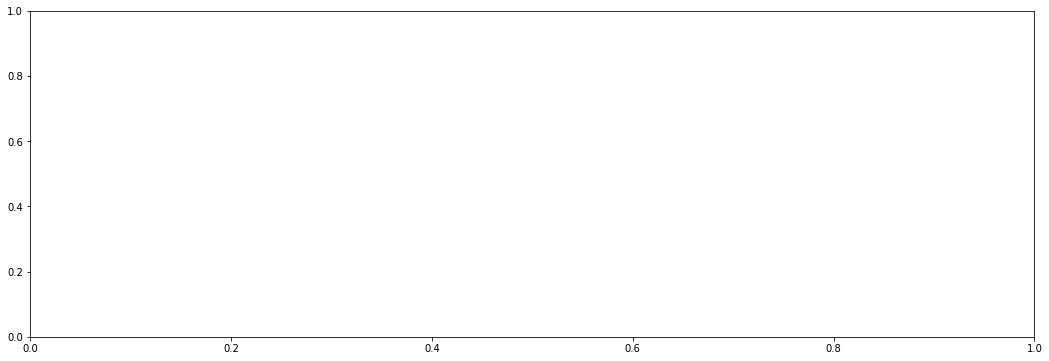

In [11]:
# plot of total tracer concentration as a function of time. 

fig = plt.figure(figsize=(18, 6))
ax  = plt.axes()
cax = ax.plot(t,C_total)

### Speed, vorticity and kinetic energy

The passive tracer allows us to visualize the effect of the flow. But we can also look directly at the flow itself. We saved snapshots of the speed `V` and the vorticity `omega`. We also saved profiles of the velocity in the $x$-direction `u_profile` and the total kinetic energy `KE`. Adapt the python scripts we used for the tracer concentration to make a movies of the speed and vorticity, profiles of the $x$-velocity, and a time series of the kinetic energy. (You can use different colormaps for the plots of speed and vorticity, e.g. `viridis` for speed and `coolwarm` for vorticity. Remember that speed is non-negative, but vorticity can take either sign.)

# Now try it for yourself

- You have seen that the dissipation of the concentration field and the total energy is caused by the diffusion term in the momentum and passive tracer equations. Try changing the value of the diffusivity $A$. How does increasing or decreasing this value modify the flow?

- Explore the dependence of the instability on the choice of initial perturbation $v$. What happens if the perturbation has no $y$ dependence, or no $x$ dependence? What happens if the amplitude of the perturbation is much smaller, or much larger? 

- Consider other initial velocity profiles, such as a Gaussian jet
$$
u(x,y,0) = U_0 \, \mbox{e}^{-y^2/a^2}, 
$$
where $U_0$ is the strength of the jet and $a$ is the width of the jet. Remember that you will need to change the boundary conditions for $u$ at $y = -Ly/2$ and $y = Ly/2$ so that they match your new velocity profile. 

- How does this velocity profile evolve differently? Can you come up with a velocity profile that is stable to small perturbations? 